## Data Processing

In [2]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
file_path = "Continuous_Orders-GB-20210627-20210628T042939000Z.csv"
df_csv = pd.read_csv(file_path, skiprows=1, low_memory=False)

df_csv.columns = df_csv.columns.str.strip()
df_csv.head()

,OrderId,InitialId,ParentId,Side,Product,DeliveryStart,DeliveryEnd,CreationTime,DeliveryArea,ExecutionRestriction,...,RevisionNo,ActionCode,TransactionTime,ValidityTime,Price,Currency,Quantity,QuantityUnit,Volume,VolumeUnit
0,11592803908,11592803908,NaN,BUY,GB_4_Hour_Power,2021-06-26T22:00:00Z,2021-06-27T02:00:00Z,2021-06-25T23:00:03.078Z,GB,NON,...,1,A,2021-06-25T23:00:03.078Z,NaN,-199.0,GBP,5.4,MAW,21.6,MWH
1,11592803909,11592803909,NaN,SELL,GB_4_Hour_Power,2021-06-26T22:00:00Z,2021-06-27T02:00:00Z,2021-06-25T23:00:03.078Z,GB,NON,...,1,A,2021-06-25T23:00:03.078Z,NaN,199.0,GBP,5.8,MAW,23.2,MWH
2,11592803908,11592803908,NaN,BUY,GB_4_Hour_Power,2021-06-26T22:00:00Z,2021-06-27T02:00:00Z,2021-06-25T23:00:03.078Z,GB,NON,...,2,D,2021-06-26T04:05:08.969Z,NaN,-199.0,GBP,5.4,MAW,21.6,MWH
3,11592803909,11592803909,NaN,SELL,GB_4_Hour_Power,2021-06-26T22:00:00Z,2021-06-27T02:00:00Z,2021-06-25T23:00:03.078Z,GB,NON,...,2,D,2021-06-26T04:05:08.969Z,NaN,199.0,GBP,5.8,MAW,23.2,MWH
4,11593182772,11593182772,NaN,BUY,GB_4_Hour_Power,2021-06-26T22:00:00Z,2021-06-27T02:00:00Z,2021-06-26T04:05:36.311Z,GB,NON,...,1,A,2021-06-26T04:05:36.311Z,NaN,-199.0,GBP,5.1,MAW,20.4,MWH


In [27]:
# Step 1: Identify the most common DeliveryStart
top_delivery = df_csv['DeliveryStart'].value_counts().idxmax()

# Step 2: Filter orders with that DeliveryStart
df_delivery = df_csv[df_csv['DeliveryStart'] == top_delivery].copy()

# Step 3: Clean necessary fields
df_delivery['TransactionTime'] = pd.to_datetime(df_delivery['TransactionTime'], errors='coerce')
df_delivery = df_delivery.dropna(subset=['TransactionTime', 'Price', 'Quantity'])
df_delivery['Price'] = df_delivery['Price'].astype(float).abs()
df_delivery['Quantity'] = df_delivery['Quantity'].astype(float)

# Step 4: Create 5-minute buckets
df_delivery['TimeBucket'] = df_delivery['TransactionTime'].dt.floor('5min')

# Step 5: Choose the most active 5-minute bucket within this delivery period
active_bucket_delivery = df_delivery['TimeBucket'].value_counts().idxmax()
df_bucket = df_delivery[df_delivery['TimeBucket'] == active_bucket_delivery]

# Step 6: Remove price outliers via IQR
q1 = df_bucket['Price'].quantile(0.25)
q3 = df_bucket['Price'].quantile(0.75)
iqr = q3 - q1
low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
df_bucket_filtered = df_bucket[(df_bucket['Price'] >= low) & (df_bucket['Price'] <= high)]

# Step 7: Group and calculate metrics
bids = df_bucket_filtered[df_bucket_filtered['Side'] == 'BUY']
asks = df_bucket_filtered[df_bucket_filtered['Side'] == 'SELL']
bid_grouped = bids.groupby('Price')['Quantity'].sum().reset_index().sort_values(by='Price')
ask_grouped = asks.groupby('Price')['Quantity'].sum().reset_index().sort_values(by='Price')

best_bid = bid_grouped['Price'].max()
best_ask = ask_grouped['Price'].min()
Y_t = (best_bid + best_ask) / 2
h_t = (best_ask - best_bid) / 2

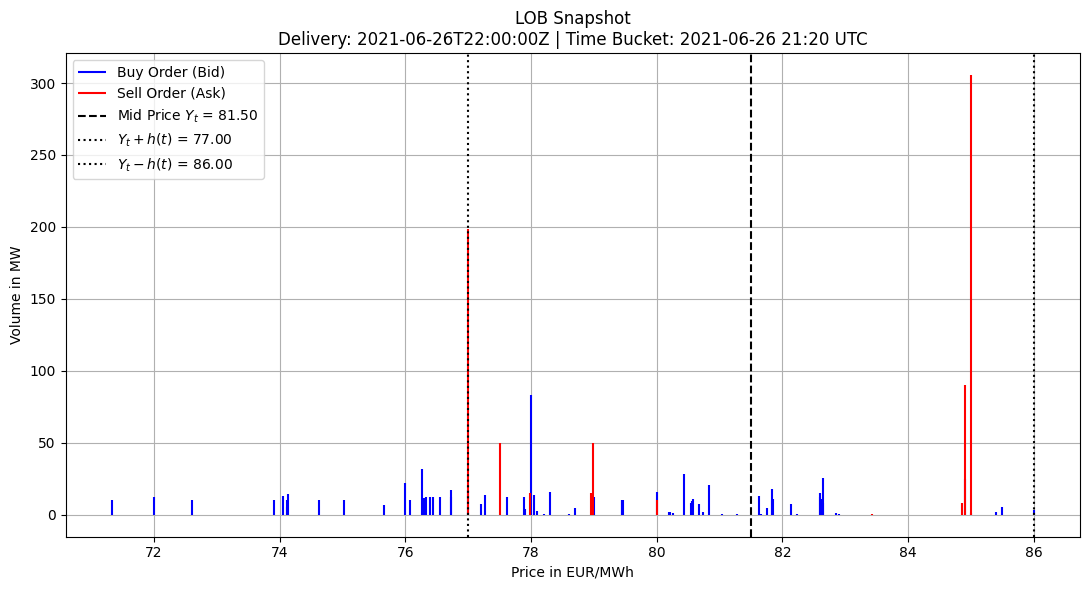

In [28]:
# Plot the LOB after filtering by DeliveryStart and TimeBucket
plt.figure(figsize=(11, 6))
plt.vlines(bid_grouped['Price'], 0, bid_grouped['Quantity'], color='blue', label='Buy Order (Bid)')
plt.vlines(ask_grouped['Price'], 0, ask_grouped['Quantity'], color='red', label='Sell Order (Ask)')
plt.axvline(Y_t, color='black', linestyle='--', label=f'Mid Price $Y_t$ = {Y_t:.2f}')
plt.axvline(Y_t + h_t, color='black', linestyle=':', label=f'$Y_t + h(t)$ = {Y_t + h_t:.2f}')
plt.axvline(Y_t - h_t, color='black', linestyle=':', label=f'$Y_t - h(t)$ = {Y_t - h_t:.2f}')

plt.xlabel('Price in EUR/MWh')
plt.ylabel('Volume in MW')
plt.title(f'LOB Snapshot\nDelivery: {top_delivery} | Time Bucket: {active_bucket_delivery.strftime("%Y-%m-%d %H:%M UTC")}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

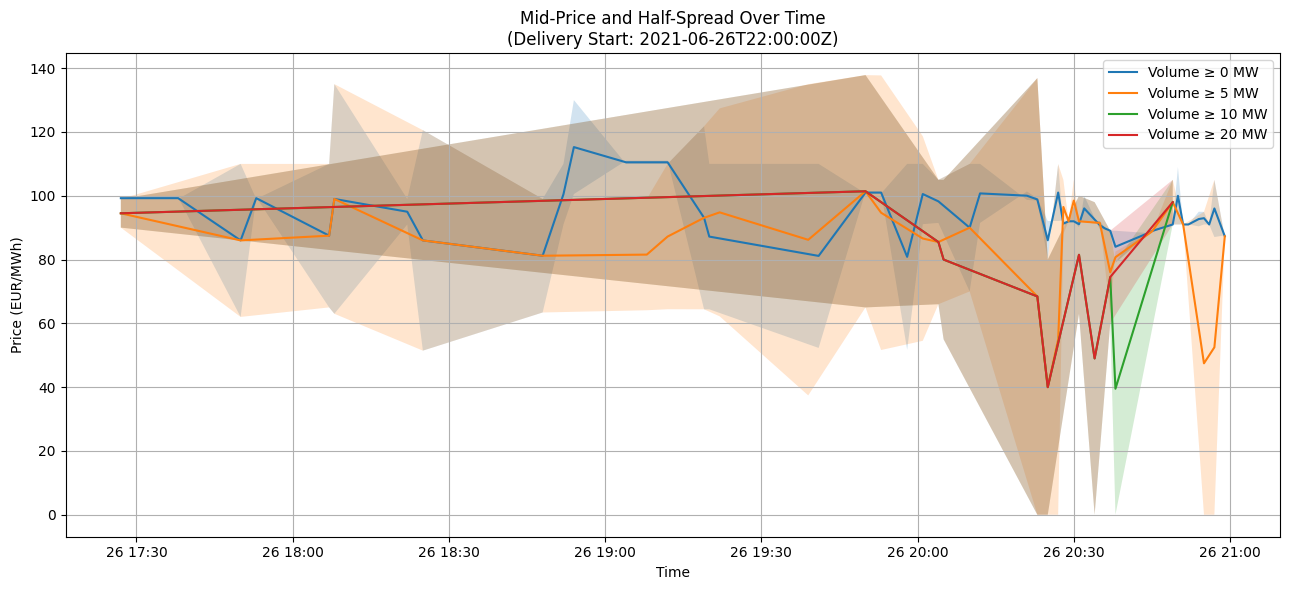

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
file_path = "Continuous_Orders-GB-20210627-20210628T042939000Z.csv"
df = pd.read_csv(file_path, skiprows=1, low_memory=False)

# --- STEP 1: FILTER FOR SPECIFIC DELIVERY START ---
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'], errors='coerce')
top_delivery = df['DeliveryStart'].value_counts().idxmax()
df = df[df['DeliveryStart'] == top_delivery]

# --- STEP 2: CLEAN DATA ---
df = df.dropna(subset=['TransactionTime', 'Price', 'Quantity', 'Side'])
df['Price'] = df['Price'].astype(float).abs()
df['Quantity'] = df['Quantity'].astype(float)

# Filter by selected time window
start_hour = 17
end_hour = 21
df = df[(df['TransactionTime'].dt.hour >= start_hour) & (df['TransactionTime'].dt.hour < end_hour)].copy()
df['TimeBucket'] = df['TransactionTime'].dt.floor('1min')

# --- STEP 3: GROUP DATA ---
grouped = df.groupby('TimeBucket')

# --- STEP 4: FUNCTION TO COMPUTE MID + SPREAD AT VOLUME LEVEL ---
def compute_mid_spread(df_grouped, volume_threshold):
    mids, spreads, times = [], [], []

    for time, group in df_grouped:
        bids = group[(group['Side'] == 'BUY') & (group['Quantity'] >= volume_threshold)]
        asks = group[(group['Side'] == 'SELL') & (group['Quantity'] >= volume_threshold)]

        # Remove outliers based on IQR
        combined = pd.concat([bids[['Price']], asks[['Price']]])
        q1 = combined['Price'].quantile(0.25)
        q3 = combined['Price'].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        bids = bids[(bids['Price'] >= lower) & (bids['Price'] <= upper)]
        asks = asks[(asks['Price'] >= lower) & (asks['Price'] <= upper)]

        if not bids.empty and not asks.empty:
            best_bid = bids['Price'].max()
            best_ask = asks['Price'].min()
            mid = (best_bid + best_ask) / 2
            spread = (best_ask - best_bid) / 2

            mids.append(mid)
            spreads.append(spread)
            times.append(time)

    return pd.DataFrame({'Time': times, 'MidPrice': mids, 'HalfSpread': spreads})

# --- STEP 5: APPLY TO MULTIPLE VOLUME THRESHOLDS ---
volume_levels = [0, 5, 10, 20]
spread_curves = {v: compute_mid_spread(grouped, v) for v in volume_levels}

# --- STEP 6: PLOT RESULTS ---
plt.figure(figsize=(13, 6))
for v, df in spread_curves.items():
    df.dropna(subset=['Time', 'MidPrice', 'HalfSpread'], inplace=True)
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce').dt.tz_localize(None)
    x = df['Time'].to_numpy()
    y = df['MidPrice'].to_numpy(dtype=np.float64)
    h = df['HalfSpread'].to_numpy(dtype=np.float64)
    plt.plot(x, y, label=f'Volume ≥ {v} MW')
    plt.fill_between(x, y - h, y + h, alpha=0.2)

plt.xlabel('Time')
plt.ylabel('Price (EUR/MWh)')
plt.title(f'Mid-Price and Half-Spread Over Time\n(Delivery Start: {top_delivery})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()